In [1]:
import sys
import os
import glob as gb
sys.path.append('/home/cbenitez/')
import MTmp as mt
import matplotlib.pyplot as plt
import numpy as np
import oort_cons as oc

amrviewer GUI ImportError : are WxPython and PyTables correctly installed?


In [2]:
def theta_spread(MCMCrun,ivc):
    nsamples,flattened_chain = MCMCrun.Nwalkers*20, MCMCrun.sampler.get_chain(flat=True,discard=MCMCrun.Nsteps-MCMCrun.Nwalkers*20)
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    fch = [oc.vr_model_ext,oc.vell_model_ext,oc.vb_model_ext][ivc]
    for i in thetas:
        aux = np.copy(MCMCrun.cc_galac)
        bsorted = aux[MCMCrun.cc_galac[:,2].argsort()]
        lsorted = bsorted[bsorted[:,1].argsort()]
        mod = np.array([fch(c,i)/c[0] for c in lsorted])
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.mean(models,axis=0)
    return lsorted,med_model,spread

____

In [3]:
DFparts,DFlsrs = mt.read_dat("/fs/nas14/other0/cbenitez/partsSim/",'mp_marbles_15032021-003752') 

In [4]:
DFparts.creation_time=DFparts.creation_time*mt.C.s.express(mt.C.Myr)
DFlsrs.creation_time=DFlsrs.creation_time*mt.C.s.express(mt.C.Myr)

In [5]:
np.unique(DFparts["output"])

array([11, 12, 13, 14, 15, 16])

In [6]:
MCMCfit13ttbin = np.load("/fs/nas14/other0/cbenitez/Notebooks/MCMCfit13ttbin.npy")
MCMCfit12ttbin = np.load("/fs/nas14/other0/cbenitez/Notebooks/MCMCfit12ttbin.npy")

In [7]:
np.shape(MCMCfit13ttbin),np.shape(MCMCfit12ttbin)

((2, 3), (3, 3))

In [8]:
def vell_ext(c,theta):
    A,B,C,K,D,d,E,e,k = theta
    #return c[0]*np.cos(c[2])*(B+A*np.cos(2*c[1])-C*np.sin(2*c[1]))-v_LSR[0]*np.sin(c[1])-v_LSR[1]*np.cos(c[1])
    return c[0]*(-(D+d)*np.sin(c[2])*np.cos(c[1])+(E+e)*np.sin(c[2])*np.sin(c[1]))

def vell_base(c,theta):
    A,B,C,K,D,d,E,e,k = theta
    #return c[0]*np.cos(c[2])*(B+A*np.cos(2*c[1])-C*np.sin(2*c[1]))-v_LSR[0]*np.sin(c[1])-v_LSR[1]*np.cos(c[1])
    return c[0]*(B*np.cos(c[2])+A*np.cos(2*c[1])*np.cos(c[2])-C*np.sin(2*c[1])*np.cos(c[2]))

def vell_model_ext(c,theta):
    A,B,C,K,D,d,E,e,k = theta
    #return c[0]*np.cos(c[2])*(B+A*np.cos(2*c[1])-C*np.sin(2*c[1]))-v_LSR[0]*np.sin(c[1])-v_LSR[1]*np.cos(c[1])
    return c[0]*(B*np.cos(c[2])+A*np.cos(2*c[1])*np.cos(c[2])-C*np.sin(2*c[1])*np.cos(c[2])\
    -(D+d)*np.sin(c[2])*np.cos(c[1])+(E+e)*np.sin(c[2])*np.sin(c[1]))


In [9]:
prue = MCMCfit12ttbin[2][2]

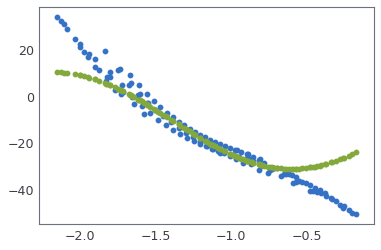

In [10]:
#plt.scatter(prue.cc_galac[:,1],prue.vv_galac[:,1])
#plt.scatter(prue.cc_galac[:,1],np.array([vell_model_ext(c,prue.theta) for c in prue.cc_galac]))
plt.scatter(prue.cc_galac[:,1],(prue.vv_galac[:,1]-np.array([vell_ext(c,prue.theta) for c in prue.cc_galac]))/np.cos(prue.cc_galac[:,2])/prue.cc_galac[:,0])
#plt.scatter(prue.cc_galac[:,1],np.array([vell_ext(c,prue.theta) for c in prue.cc_galac]))
plt.scatter(prue.cc_galac[:,1],np.array([vell_base(c,prue.theta)/np.cos(c[2])/c[0] for c in prue.cc_galac]))

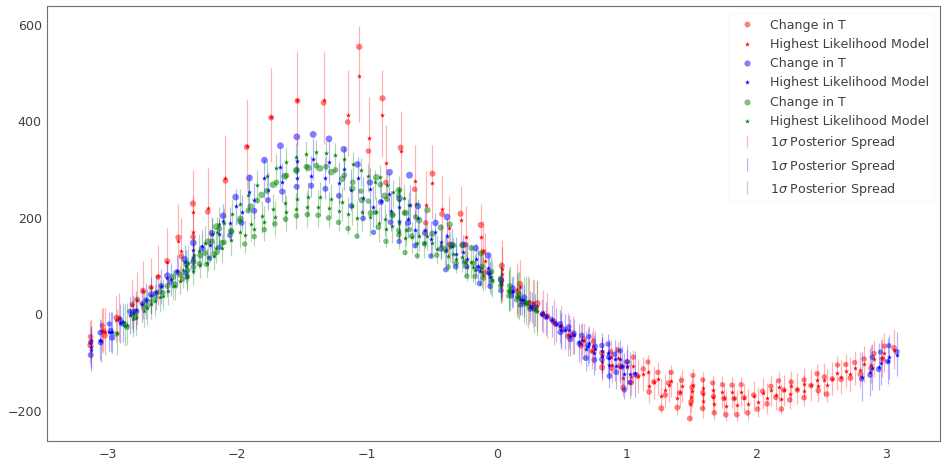

In [11]:
ivc = 0
MCMCfits = MCMCfit12ttbin[0]
colors = ["red","blue","green"]
ll = np.linspace(-np.pi,np.pi,200)
fvc = [oc.vr_model_ext,oc.vell_model_ext,oc.vb_model_ext][ivc]
plt.figure(figsize=(16,8))
for ibc in range(0,3):
    MCMCrun=MCMCfits[ibc]
    lsorted, med_model, spread = theta_spread(MCMCrun,ivc)
    plt.scatter(MCMCrun.cc_galac[:,1],MCMCrun.vv_galac[:,ivc]/MCMCrun.cc_galac[:,0],label='Change in T',s=MCMCrun.dd*10,alpha=.5,color=colors[ibc])
    plt.scatter(MCMCrun.cc_galac[:,1],[fvc(c,MCMCrun.theta)/c[0] for c in MCMCrun.cc_galac],label='Highest Likelihood Model',s=20,color=colors[ibc],marker="*" )
    plt.errorbar(lsorted[:,1],med_model,yerr=spread,color=colors[ibc],alpha=0.3,linestyle='',label=r'$1\sigma$ Posterior Spread')
    #plt.plot(lsorted[:,1],med_model,color=colors[ibc],alpha=0.8,label=r'$1\sigma$ Posterior Spread',ls="--")
plt.legend()

In [12]:
def plot_spreads(MCMCfits,Mn,filename=None):

    ll = np.linspace(-np.pi,np.pi,200)
    colors = ["red","blue","green"]
    ylabs = ['$v_r/r$\n[km s$^{-1}$ kpc$^{-1}$]','$v_{\ell}/r$\n[km s$^{-1}$ kpc$^{-1}$]','$v_{b}/r$\n[km s$^{-1}$ kpc$^{-1}$]']
    
    fig, axs = plt.subplots(3, 1, figsize=(18,18),sharex=True)

    for ivc in range(3):
        fvc = [oc.vr_model_ext,oc.vell_model_ext,oc.vb_model_ext][ivc]
        for ibc in range(0,3):
            MCMCrun=MCMCfits[ibc]
            lsorted, med_model, spread = theta_spread(MCMCrun,ivc)
            axs[ivc].scatter(MCMCrun.cc_galac[:,1],MCMCrun.vv_galac[:,ivc]/MCMCrun.cc_galac[:,0],label='$M_{%g}^{%g}$'%(Mn,ibc+1),s=MCMCrun.dd*10,alpha=.5,color=colors[ibc])
            axs[ivc].scatter(MCMCrun.cc_galac[:,1],[fvc(c,MCMCrun.theta)/c[0] for c in MCMCrun.cc_galac],label='Ajuste $M_{%g}^{%g}$'%(Mn,ibc+1),s=30,color=colors[ibc],marker="*" )
            axs[ivc].errorbar(lsorted[:,1],med_model,yerr=spread,color=colors[ibc],alpha=.5,linestyle='',label=r'')
            #plt.plot(lsorted[:,1],med_model,color=colors[ibc],alpha=0.8,label=r'$1\sigma$ Posterior Spread',ls="--")
            axs[ivc].set_ylabel(ylabs[ivc],fontsize=24)
        axs[0].legend()

    axs[ivc].locator_params(nbins=7)
    axs[ivc].locator_params(nbins=7)
    axs[ivc].locator_params(nbins=7)

        
    axs[2].set_xlabel(r'$\ell$  [deg]',fontsize=24)

    axs[2].set_xticks([l for l in np.linspace(np.pi,-np.pi,9)])
    axs[2].set_xticklabels(labels=[str(int(l)) for l in np.linspace(180,-180,9)])

    for ax in axs:
        ax.tick_params(which='major',direction='in',right=True,top=True,length=6)
        ax.tick_params(which='minor',direction='in',right=True,top=True,length=4)
        ax.xaxis.set_tick_params(labelsize=16)
        ax.yaxis.set_tick_params(labelsize=16)
        ax.invert_xaxis()
        
    plt.subplots_adjust(hspace=0,wspace=.35)
    if filename!=None:
        plt.savefig(filename+".pdf", format='pdf',bbox_inches='tight')

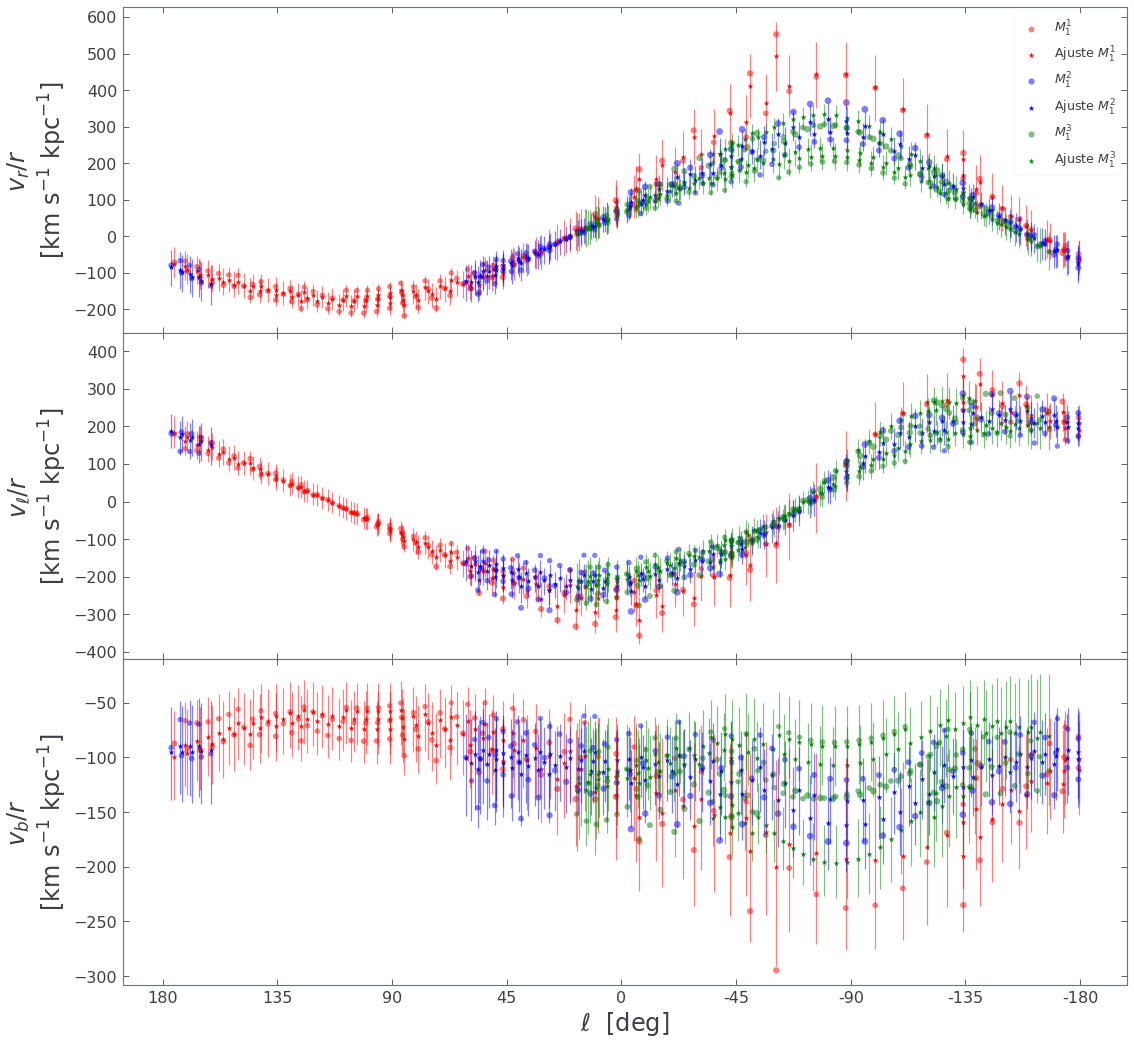

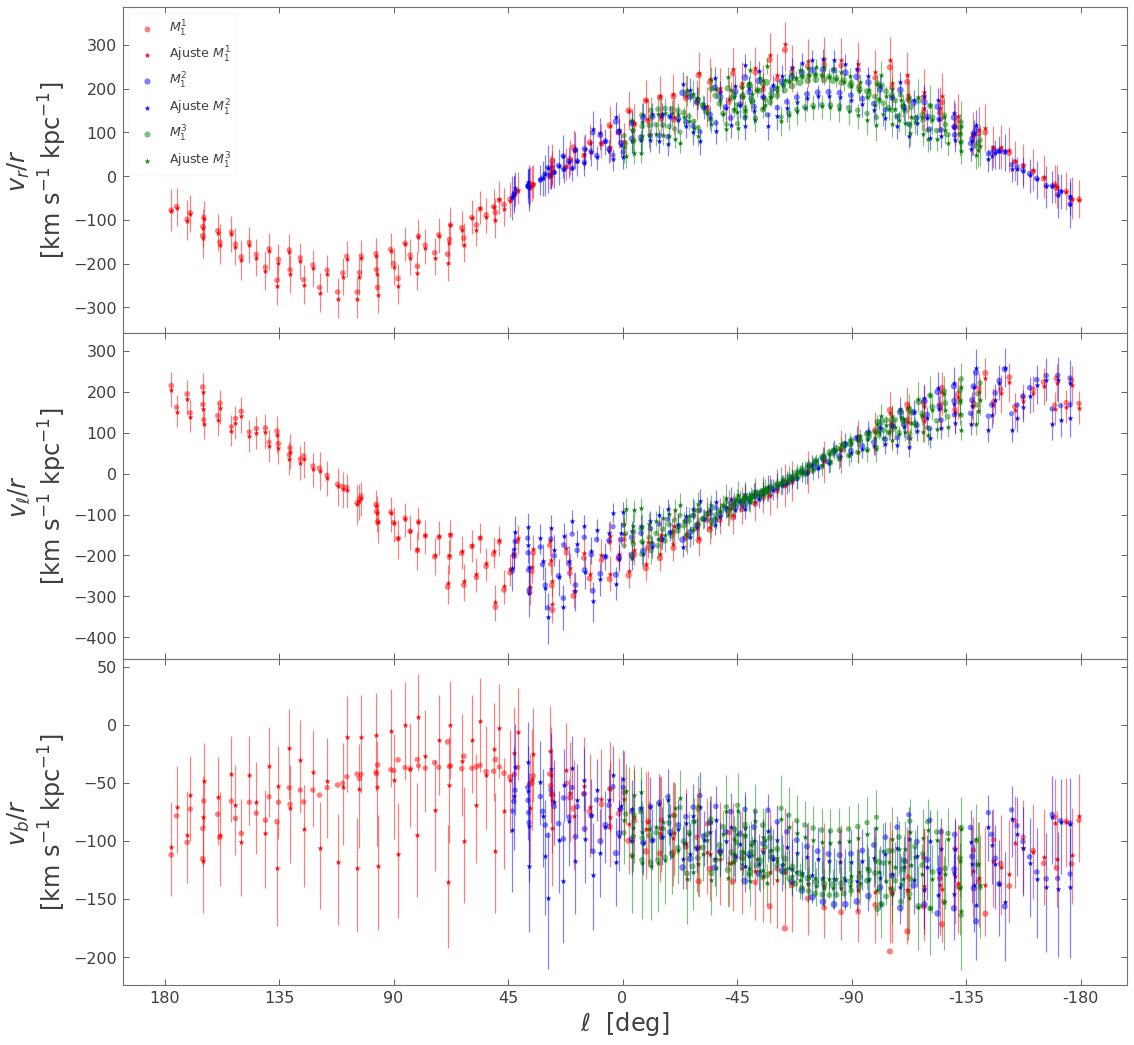

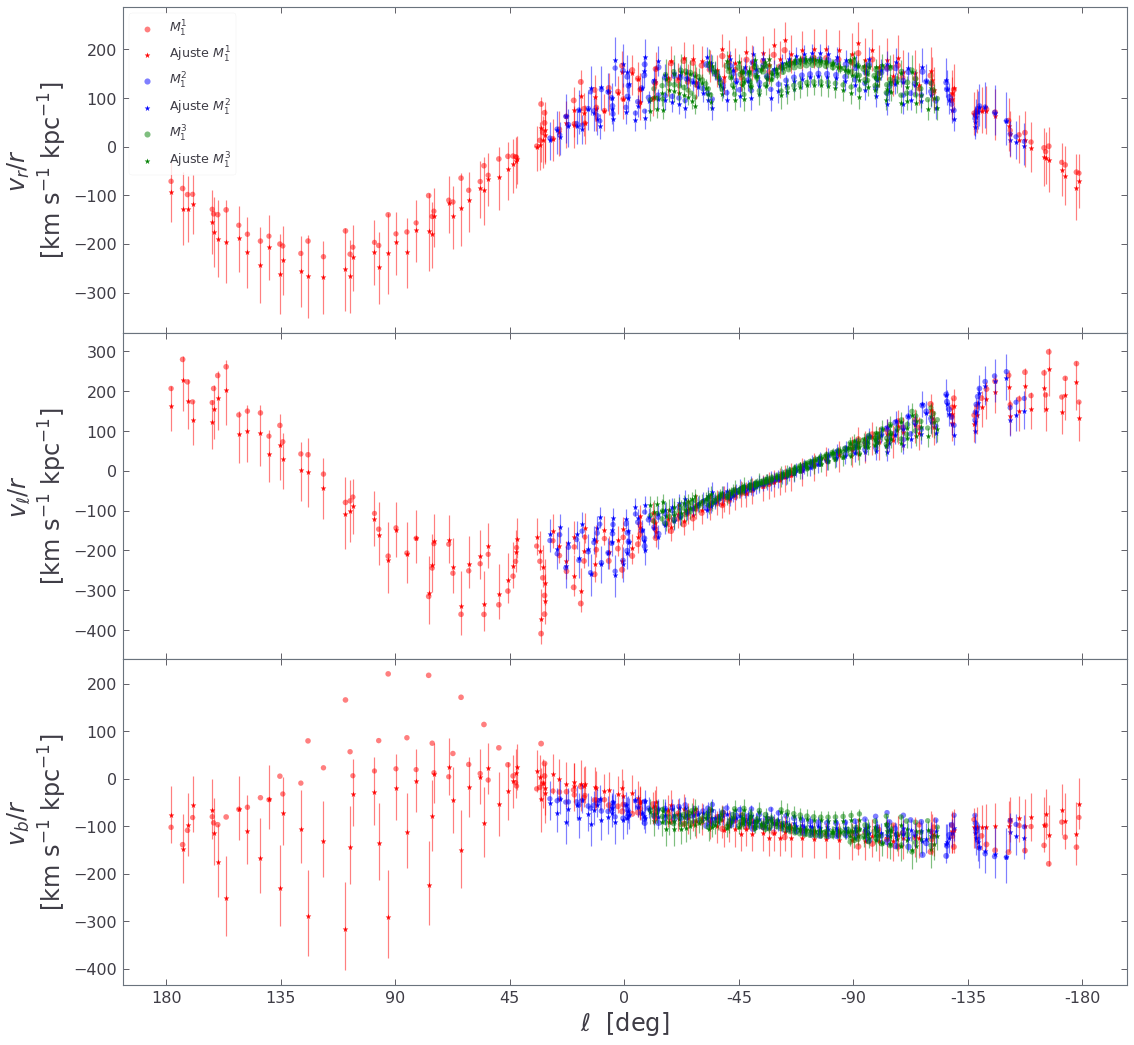

In [13]:
for tc in range(3):
    MCMCfits = MCMCfit12ttbin[tc]
    plot_spreads(MCMCfits,1,filename="ajustes M1 t%g"%(tc+1))

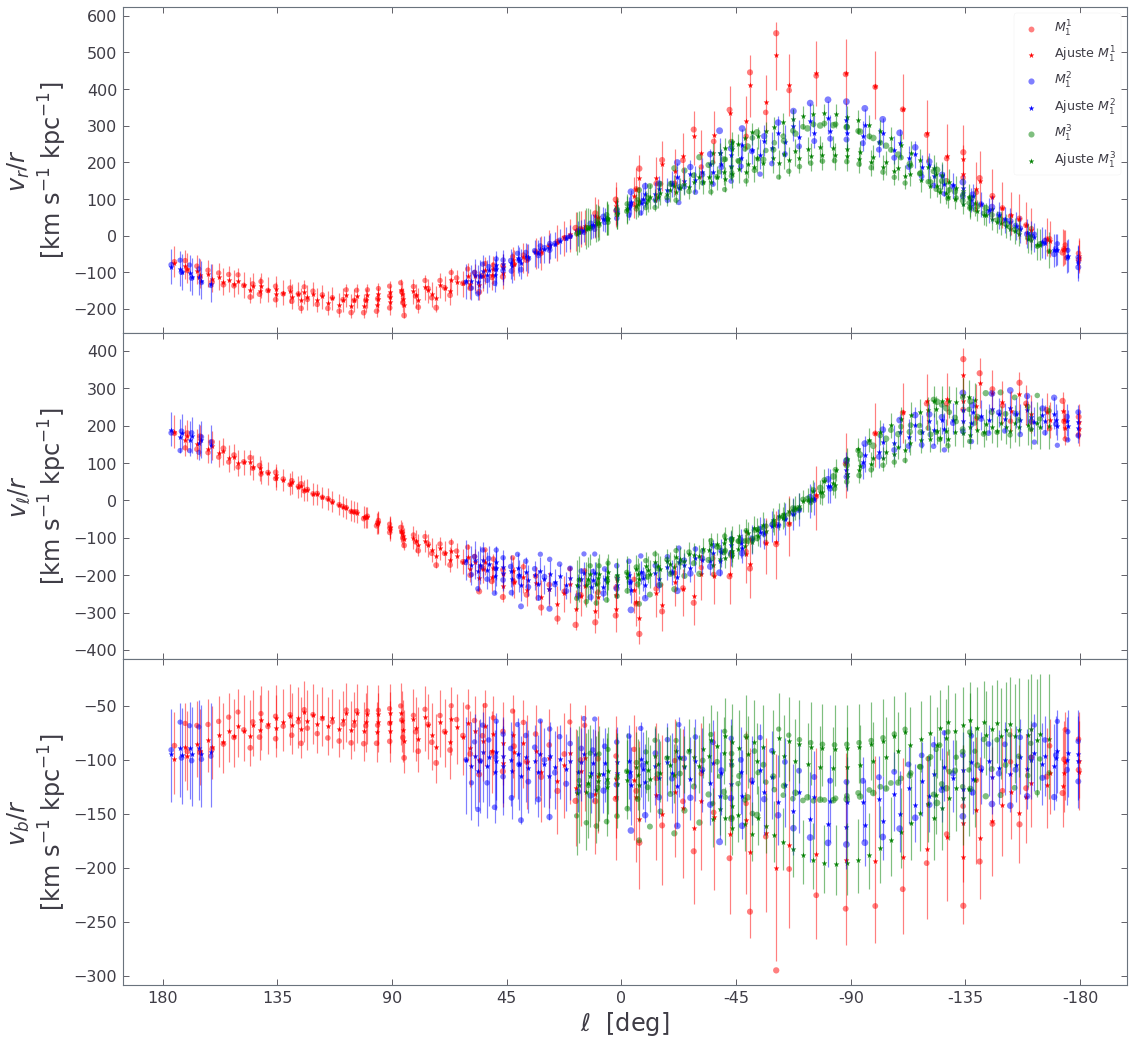

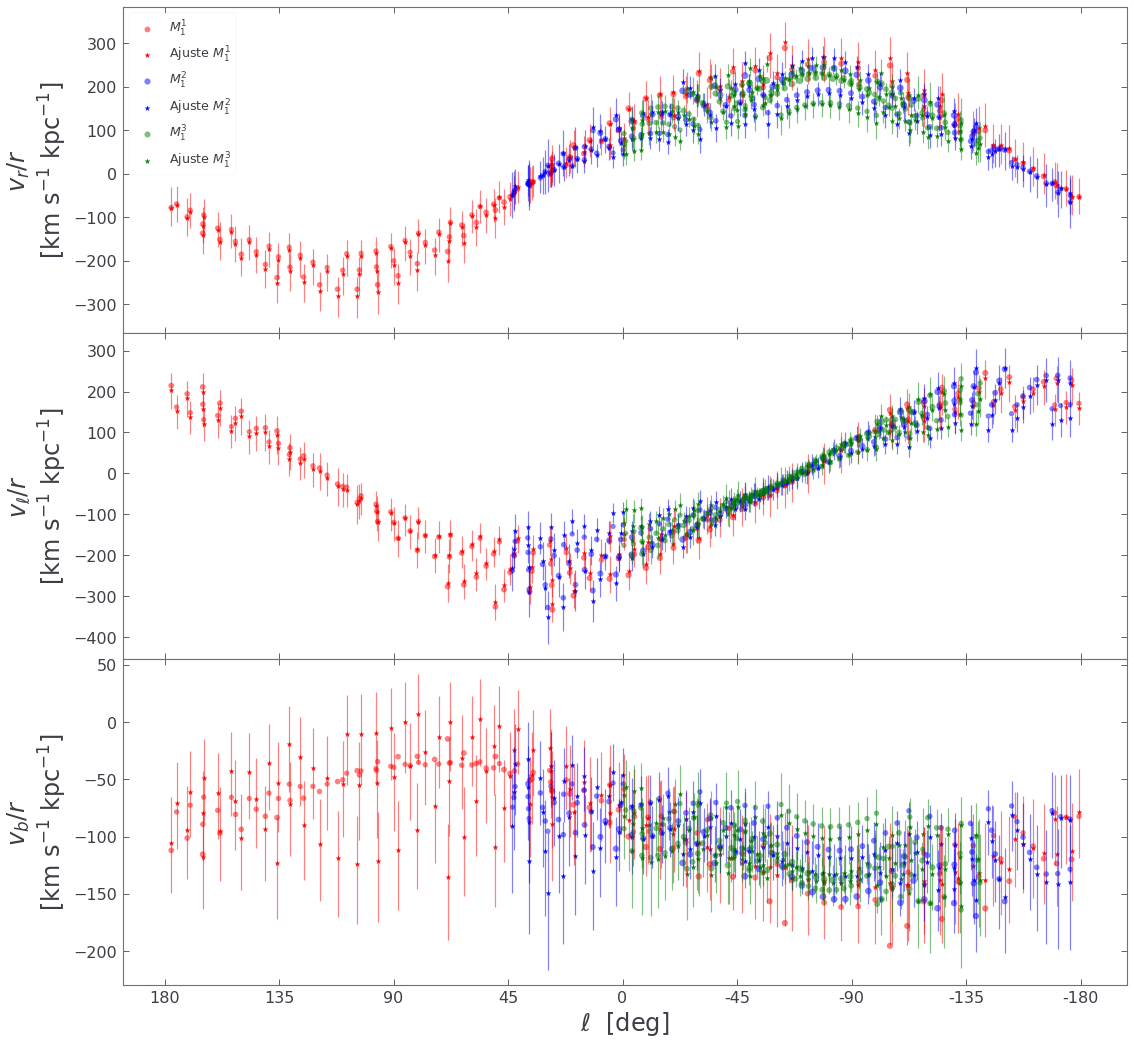

In [14]:
for tc in range(2):
    MCMCfits = MCMCfit12ttbin[tc]
    plot_spreads(MCMCfits,1,filename="ajustes M2 t%g"%(tc+1))